In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.conv3 = nn.Conv2d(64, 10, 3, 1)

    def forward(self, x):
        for conv_layer in [self.conv1, self.conv2, self.conv3]:
            x = conv_layer(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = F.softmax(x, dim=1)
        return output

In [3]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1%})]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1%})\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

In [5]:
batch_size = 50
test_batch_size = 500
epochs = 10
learning_rate = 1.0
gamma = 0.7
no_cuda = False
seed = 1
log_interval = 50

In [6]:
use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [7]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
losses = []
error_rates = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    (loss, accuracy) = test(model, device, test_loader)
    losses.append(loss)
    error_rates.append(1 - accuracy)
    scheduler.step()

Train Epoch: 1 [0/60000 (0.0%)]	Loss: 2.305270
Train Epoch: 1 [2500/60000 (4.2%)]	Loss: 1.923400
Train Epoch: 1 [5000/60000 (8.3%)]	Loss: 1.818574
Train Epoch: 1 [7500/60000 (12.5%)]	Loss: 1.668814
Train Epoch: 1 [10000/60000 (16.7%)]	Loss: 1.716618
Train Epoch: 1 [12500/60000 (20.8%)]	Loss: 1.770349
Train Epoch: 1 [15000/60000 (25.0%)]	Loss: 1.705264
Train Epoch: 1 [17500/60000 (29.2%)]	Loss: 1.750362
Train Epoch: 1 [20000/60000 (33.3%)]	Loss: 1.719816
Train Epoch: 1 [22500/60000 (37.5%)]	Loss: 1.772244
Train Epoch: 1 [25000/60000 (41.7%)]	Loss: 1.715858
Train Epoch: 1 [27500/60000 (45.8%)]	Loss: 1.661509
Train Epoch: 1 [30000/60000 (50.0%)]	Loss: 1.703886
Train Epoch: 1 [32500/60000 (54.2%)]	Loss: 1.677483
Train Epoch: 1 [35000/60000 (58.3%)]	Loss: 1.660676
Train Epoch: 1 [37500/60000 (62.5%)]	Loss: 1.746571
Train Epoch: 1 [40000/60000 (66.7%)]	Loss: 1.727081
Train Epoch: 1 [42500/60000 (70.8%)]	Loss: 1.636485
Train Epoch: 1 [45000/60000 (75.0%)]	Loss: 1.688482
Train Epoch: 1 [47500/

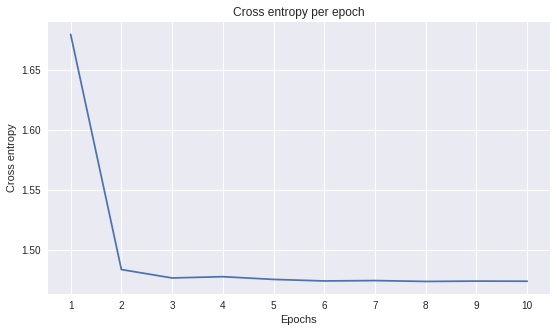

In [8]:
plt.figure(figsize=(9, 5))
plt.title('Cross entropy per epoch')
plt.xlabel('Epochs')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Cross entropy')
plt.grid(True)

plt.plot(range(1, epochs + 1), losses)
plt.show()

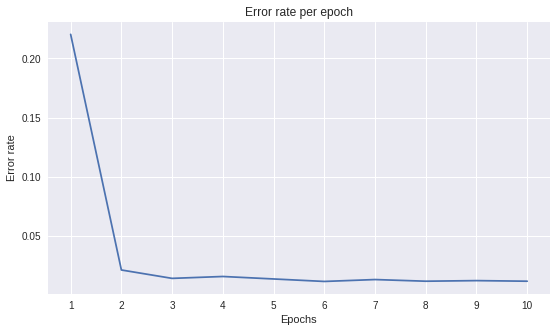

In [9]:
plt.figure(figsize=(9, 5))
plt.title('Error rate per epoch')
plt.xlabel('Epochs')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Error rate')
plt.grid(True)

plt.plot(range(1, epochs + 1), error_rates)
plt.show()